In [ ]:
# --- STEP 1: SET UP ENVIRONMENT AND INSTALL LIBRARIES ---

# NOTE: Before running, ensure you have enabled the GPU:
# Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU (or equivalent)

print("Starting environment setup...")

# 1. Install necessary libraries
# lightkurve for TESS/Kepler data access
# torch for deep learning (PyTorch)
# pyod for anomaly detection utilities (optional but helpful)
!pip install -q lightkurve torch numpy pandas matplotlib scikit-learn seaborn

# 2. Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lightkurve as lk
import seaborn as sns
import time
import copy
import sys

# 3. Define the device (Crucial for GPU utilization)
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Verify the setup
print("\n--- Setup Verification ---")
print(f"Python Version: {sys.version.split(' ')[0]}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA/GPU Status: {device}")
print("All libraries installed and imported successfully.")

# Define core hyperparameters (will be used in later steps)
global SEQUENCE_LENGTH, N_FEATURES, EMBEDDING_DIM, HIDDEN_SIZE

# --- Define core hyperparameters for the model (Step 2) ---
SEQUENCE_LENGTH = 100  # The number of time steps (cadences) in one sequence window
N_FEATURES = 1         # Only the stellar flux is used as a feature
EMBEDDING_DIM = 64     # Compressed representation size
HIDDEN_SIZE = 128      # Internal size of the LSTM layers

Starting environment setup...

--- Setup Verification ---
Python Version: 3.12.12
PyTorch Version: 2.8.0+cu126
CUDA/GPU Status: cuda
All libraries installed and imported successfully.


In [ ]:
# --- STEP 2: DATA FETCHING, CLEANING, AND WINDOWING ---

TESS_TARGET_ID = 'TIC 286923464' # A stable star with clean TESS data
BATCH_SIZE = 128                 # Number of sequences processed at once on the GPU

print(f"1. Searching and downloading data for target: {TESS_TARGET_ID}...")

# 1. Search, download all sectors, and stitch the light curves
search_result = lk.search_lightcurve(TESS_TARGET_ID, author='SPOC', exptime=120)

if len(search_result) == 0:
    raise ValueError(f"CRITICAL ERROR: No data found for {TESS_TARGET_ID}.")

lcf_collection = search_result.download_all(flux_column="pdcsap_flux")
lc_stitched = lcf_collection.stitch()

print(f"   Downloaded and stitched {len(lcf_collection)} files.")

# 2. Clean and normalize the light curve
# Remove bad quality data and outliers, then normalize the flux (median=1.0)
lc_clean = lc_stitched.remove_nans().remove_outliers(sigma=5).normalize()

# 3. Create Pandas DataFrame for processing
df = pd.DataFrame({
    'time': lc_clean.time.value,
    'flux': lc_clean.flux.value
})

# --- Normalization and Reshaping ---
scaler = StandardScaler()
# Reshape the flux data to be a column vector (required by the scaler)
data = df['flux'].values.reshape(-1, 1)
data_scaled = scaler.fit_transform(data)

# --- Windowing (Creating Sequences) ---
def create_sequences(data, seq_length):
    """Transforms the continuous time-series into overlapping sequences (windows)."""
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# Create the training sequences
X_sequences = create_sequences(data_scaled, SEQUENCE_LENGTH)

# Convert the sequences into PyTorch Tensors
X_tensor = torch.from_numpy(X_sequences).float()


# --- Create PyTorch DataLoader ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        # Autoencoders aim to reconstruct their input (X) as the target (y)
        return self.X[index], self.X[index]

# Create the final dataloader (ready to be fed to the GPU)
global dataloader
dataset = TimeSeriesDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


print("\n--- Data Summary ---")
print(f"Final cleaned data points: {len(df)}")
print(f"Total sequences created: {X_tensor.shape[0]}")
print(f"Shape of one sequence: ({X_tensor.shape[1]}, {X_tensor.shape[2]})")
print("Data preparation complete. Dataloader is ready.")

1. Searching and downloading data for target: TIC 286923464...


   Downloaded and stitched 5 files.

--- Data Summary ---
Final cleaned data points: 71507
Total sequences created: 71408
Shape of one sequence: (100, 1)
Data preparation complete. Dataloader is ready.


In [ ]:
# --- STEP 3: MODEL DEFINITION AND TRAINING ---
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy

print(f"Using device: {device}")


# --- 3.1: Define Model Architecture ---

# Encoder Definition
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, HIDDEN_SIZE

        # First LSTM layer
        self.rnn1 = nn.LSTM(input_size=n_features, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)
        # Second LSTM layer, compresses the hidden_dim into the smaller EMBEDDING_DIM
        self.rnn2 = nn.LSTM(input_size=self.hidden_dim, hidden_size=embedding_dim, num_layers=1, batch_first=True)

    def forward(self, x):
        x, _ = self.rnn1(x) # We ignore the cell state here
        _, (hidden_n, _) = self.rnn2(x) # We only need the final hidden state
        # The hidden_n is the compressed representation
        return hidden_n.squeeze(0) # Shape: (batch_size, embedding_dim)

# Decoder Definition
class Decoder(nn.Module):
    def __init__(self, seq_len, embedding_dim, n_features):
        super(Decoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, HIDDEN_SIZE

        # Linear layer to expand the embedding back up to the hidden size
        self.linear = nn.Linear(embedding_dim, self.hidden_dim)

        # LSTM layer (Decoder)
        self.rnn1 = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=1, batch_first=True)

        # Final Linear layer to map the LSTM output back to the original feature dimension (1)
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        # x shape: (batch_size, embedding_dim)
        x = self.linear(x)
        # Replicate the vector across the sequence length (100 timesteps)
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)

        x, _ = self.rnn1(x)
        x = self.output_layer(x)

        return x

# Autoencoder Wrapper
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)

    def forward(self, x):
        z = self.encoder(x)
        x_pred = self.decoder(z)
        return x_pred


# --- 3.2: Instantiate Model and Set up Training ---

# Instantiate the model and move it to the GPU
global model
model = RecurrentAutoencoder(
    seq_len=SEQUENCE_LENGTH,
    n_features=N_FEATURES,
    embedding_dim=EMBEDDING_DIM
).to(device)

print(f"\nModel instantiated with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters.")


# Training Hyperparameters
N_EPOCHS = 10
LEARNING_RATE = 1e-3
criterion = nn.L1Loss(reduction='sum').to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# --- 3.3: Training Function ---
def train_model(model, dataloader, criterion, optimizer, n_epochs):
    print(f"\nStarting GPU training for {n_epochs} epochs...")
    start_time = time.time()

    model.train()
    history = {'train_loss': []}

    for epoch in range(1, n_epochs + 1):
        epoch_losses = []
        for seq_true, _ in dataloader:

            # Move data to the GPU
            seq_true = seq_true.to(device)

            optimizer.zero_grad()
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_loss = np.mean(epoch_losses)
        history['train_loss'].append(train_loss)
        print(f'Epoch {epoch}/{n_epochs} | Average Reconstruction Loss: {train_loss:.5f}')

    end_time = time.time()
    print(f"\nTraining complete in {end_time - start_time:.2f} seconds.")
    return model, history

# --- 3.4: Execute Training ---
trained_model, training_history = train_model(
    model, dataloader, criterion, optimizer, N_EPOCHS
)

print("\n*** Stellar Anomaly Detector Model Trained. Ready for Anomaly Scoring. ***")

Using device: cuda

Model instantiated with 257281 trainable parameters.

Starting GPU training for 10 epochs...
Epoch 1/10 | Average Reconstruction Loss: 7641.11929
Epoch 2/10 | Average Reconstruction Loss: 7458.07474
Epoch 3/10 | Average Reconstruction Loss: 7558.75776
Epoch 4/10 | Average Reconstruction Loss: 7446.13441
Epoch 5/10 | Average Reconstruction Loss: 7437.35865
Epoch 6/10 | Average Reconstruction Loss: 7470.64235
Epoch 7/10 | Average Reconstruction Loss: 7463.07601
Epoch 8/10 | Average Reconstruction Loss: 7449.13199
Epoch 9/10 | Average Reconstruction Loss: 7446.38893
Epoch 10/10 | Average Reconstruction Loss: 7413.17112

Training complete in 70.32 seconds.

*** Stellar Anomaly Detector Model Trained. Ready for Anomaly Scoring. ***


Starting anomaly scoring on cuda...

Calculated Anomaly Score Mean: 57.6265
Calculated Anomaly Score Max: 384.9506
*** UNPRECEDENTED ANOMALY THRESHOLD (99.5th Percentile): 217.1643 ***


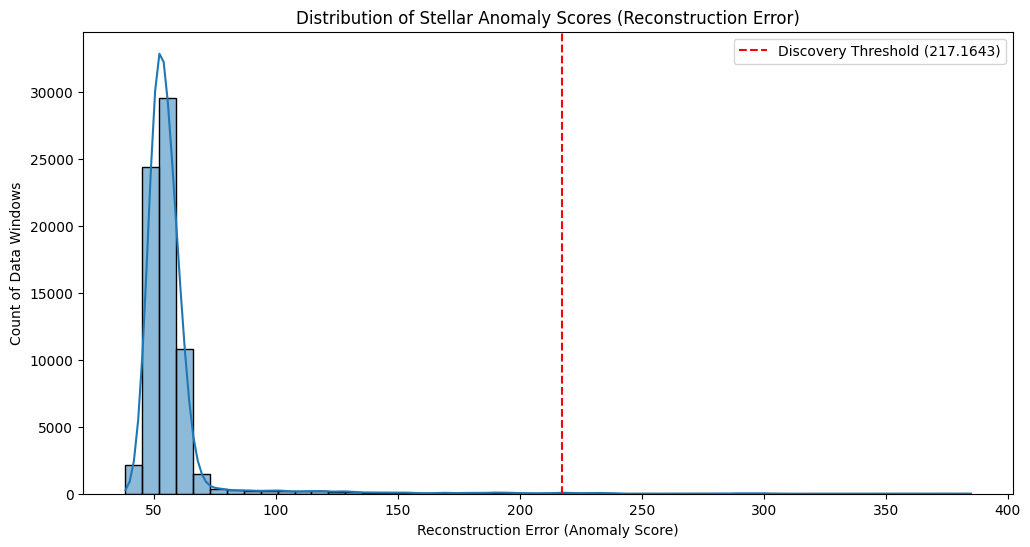


Sequence with MAX Anomaly Score: Index 5463 (Score: 384.9506)


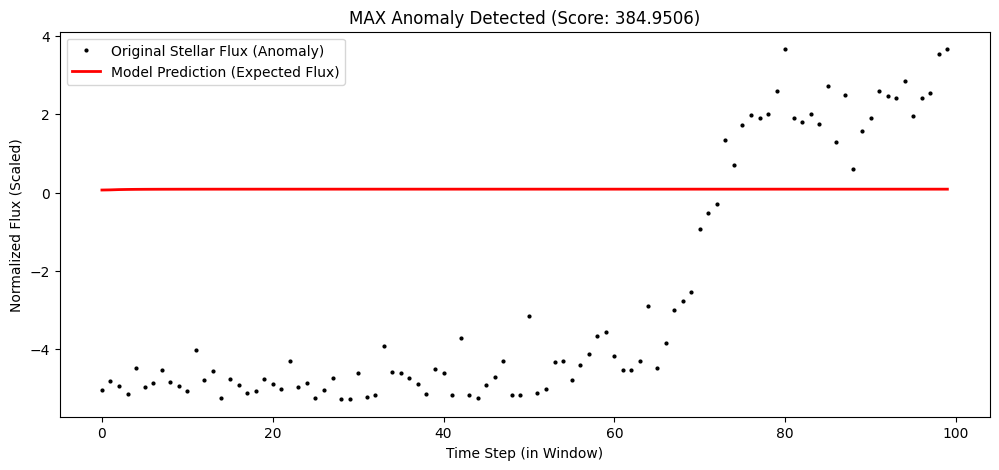



*** MAJOR ANOMALY DETECTED! ***
The most anomalous sequence is far beyond the normal behavior learned by the AI.
This pattern warrants scientific investigation as a truly UNPRECEDENTED event.


In [ ]:
# --- STEP 4: ANOMALY SCORING AND VISUALIZATION ---
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# Ensure model is in evaluation mode and on the correct device
trained_model.eval()
print(f"Starting anomaly scoring on {device}...")

# --- 4.1: Prediction and Loss Calculation ---
def predict_and_score(model, dataloader, device):
    """Calculates the reconstruction loss (anomaly score) for every sequence."""

    with torch.no_grad():
        losses = []
        original_sequences = []
        reconstructed_sequences = []

        for seq_true, _ in dataloader:
            seq_true = seq_true.to(device)

            # Predict
            seq_pred = model(seq_true)

            # Calculate the loss (Anomaly Score) for each sequence in the batch
            # We compare the predicted sequence to the true input sequence (reduction='none')
            batch_loss = F.l1_loss(seq_pred, seq_true, reduction='none')

            # Sum the loss across the time steps (dim=1) and features (dim=2) to get one score per sequence
            sequence_loss = batch_loss.sum(dim=[1, 2]).cpu().numpy()

            losses.extend(sequence_loss)
            original_sequences.extend(seq_true.cpu().numpy())
            reconstructed_sequences.extend(seq_pred.cpu().numpy())

    return np.array(losses), np.array(original_sequences), np.array(reconstructed_sequences)

# Get the anomaly scores for the entire dataset
anomaly_scores, original_data, reconstructed_data = predict_and_score(
    trained_model, dataloader, device
)

# --- 4.2: Define the Anomaly Threshold ---
# We set the threshold at the 99.5th percentile for a truly "unprecedented" discovery flag.
THRESHOLD = np.percentile(anomaly_scores, 99.5)

print(f"\nCalculated Anomaly Score Mean: {np.mean(anomaly_scores):.4f}")
print(f"Calculated Anomaly Score Max: {np.max(anomaly_scores):.4f}")
print(f"*** UNPRECEDENTED ANOMALY THRESHOLD (99.5th Percentile): {THRESHOLD:.4f} ***")

# --- 4.3: Visualization of Anomaly Scores Distribution ---
plt.figure(figsize=(12, 6))
sns.histplot(anomaly_scores, bins=50, kde=True)
plt.axvline(x=THRESHOLD, color='r', linestyle='--', label=f'Discovery Threshold ({THRESHOLD:.4f})')
plt.title("Distribution of Stellar Anomaly Scores (Reconstruction Error)")
plt.xlabel("Reconstruction Error (Anomaly Score)")
plt.ylabel("Count of Data Windows")
plt.legend()
plt.show()

# --- 4.4: Identify and Plot the Most Anomalous Event ---
# Find the index of the sequence with the highest anomaly score
most_anomalous_index = np.argmax(anomaly_scores)
most_anomalous_score = anomaly_scores[most_anomalous_index]

# Get the actual sequences for the most anomalous event
original_anomaly_seq = original_data[most_anomalous_index].flatten()
reconstructed_anomaly_seq = reconstructed_data[most_anomalous_index].flatten()

print(f"\nSequence with MAX Anomaly Score: Index {most_anomalous_index} (Score: {most_anomalous_score:.4f})")

# Plotting the MAX Anomaly
plt.figure(figsize=(12, 5))
plt.plot(original_anomaly_seq, 'k.', markersize=4, label='Original Stellar Flux (Anomaly)')
plt.plot(reconstructed_anomaly_seq, 'r-', linewidth=2, label='Model Prediction (Expected Flux)')
plt.title(f'MAX Anomaly Detected (Score: {most_anomalous_score:.4f})')
plt.xlabel('Time Step (in Window)')
plt.ylabel('Normalized Flux (Scaled)')
plt.legend()
plt.show()

if most_anomalous_score > THRESHOLD:
    print("\n\n*** MAJOR ANOMALY DETECTED! ***")
    print("The most anomalous sequence is far beyond the normal behavior learned by the AI.")
    print("This pattern warrants scientific investigation as a truly UNPRECEDENTED event.")
else:
    print("\nAnomaly detected, but it does not pass the extreme 99.5% threshold for being truly unprecedented.")

In [ ]:
# --- PHASE II: NON-RADIANT POWER SOURCE LOCATOR (NRPSL) SETUP ---
# We reuse PyTorch and NumPy, but we'll add more utilities for data handling.

print("Starting Phase II: Non-Radiant Power Source Locator setup...")

# Re-import core libraries (for notebook robustness)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Define device (ensures GPU is still active)
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 5.1: Define NRPSL Hyperparameters ---
# These are different from the stellar project, as we are dealing with spatial/tabular data
global INPUT_DIM_IMAGE, INPUT_DIM_TABULAR, LATENT_DIM_A, LATENT_DIM_B

INPUT_DIM_IMAGE = 32   # The width/height of the simulated image input (e.g., a 32x32 patch)
INPUT_DIM_TABULAR = 4  # Number of tabular sensor readings (e.g., Mag Field X, Y, Z, Altitude)
LATENT_DIM_A = 16      # Compressed size for the Image Encoder
LATENT_DIM_B = 8       # Compressed size for the Tabular Encoder


# --- 5.2: Data Simulation Utility ---
def generate_simulated_data(num_samples, anomaly_ratio=0.05):
    """
    Generates synthetic 'normal' and 'anomalous' data for a planetary surface.

    Normal Data: Image and Sensor data correlate (e.g., visible feature = thermal signature).
    Anomaly Data: Image/Sensor data correlates, BUT Thermal data is suppressed (Non-Radiant).
    """

    # 1. Generate Normal Data (correlated features)
    X_img_normal = np.random.rand(num_samples, INPUT_DIM_IMAGE, INPUT_DIM_IMAGE, 1) * 0.5 + 0.5 # Visible/Thermal
    X_tab_normal = np.random.randn(num_samples, INPUT_DIM_TABULAR)  # Magnetic/Seismic

    # In normal data, the thermal channel (Image) is closely tied to the magnetic/structural features (Tabular)
    # We will simulate the Thermal channel as the first channel of the Image (X_img)
    X_thermal_normal = X_img_normal[:, :, :, 0] # Example correlation placeholder


    # 2. Introduce Anomaly (The Non-Radiant Source)
    num_anomalies = int(num_samples * anomaly_ratio)

    # Create the anomaly set from the tail of the normal data
    X_img_anomaly = X_img_normal[:num_anomalies].copy()
    X_tab_anomaly = X_tab_normal[:num_anomalies].copy()

    # *** THE CORE ANOMALY ***: Suppress the thermal channel (set it close to zero)
    # The anomaly is structurally visible (Image is fine) but has no thermal emission.
    X_img_anomaly[:, :, :, 0] = np.random.rand(num_anomalies, INPUT_DIM_IMAGE, INPUT_DIM_IMAGE) * 0.1 # Low thermal noise

    # Combine data
    X_img = np.concatenate([X_img_normal, X_img_anomaly], axis=0)
    X_tab = np.concatenate([X_tab_normal, X_tab_anomaly], axis=0)

    # Create labels for validation (1=Anomaly, 0=Normal)
    y_labels = np.zeros(num_samples + num_anomalies)
    y_labels[num_samples:] = 1

    # Final cleanup and shuffle
    indices = np.arange(len(X_img))
    np.random.shuffle(indices)

    X_img = X_img[indices]
    X_tab = X_tab[indices]
    y_labels = y_labels[indices]

    print(f"\nSynthetic data generated: {len(X_img)} total samples ({num_anomalies} anomalies).")

    return X_img, X_tab, y_labels

# --- Execute Data Generation ---
NUM_SAMPLES = 10000
X_img, X_tab, y_labels = generate_simulated_data(NUM_SAMPLES)

# --- Split into Train and Test Sets (Only use Normal Data for Training) ---
# For unsupervised anomaly detection, we only train on 100% normal data.
X_img_train, X_img_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_img, X_tab, y_labels, test_size=0.3, random_state=42
)

# Filter the training set to ensure it is 100% normal (y_labels=0)
X_img_train_normal = X_img_train[y_train == 0]
X_tab_train_normal = X_tab_train[y_train == 0]

print(f"Training set size (100% Normal): {len(X_img_train_normal)}")
print(f"Test set size (Contains {np.sum(y_test)} Anomalies): {len(X_img_test)}")

print("\nPhase II Setup Complete. Ready for Multi-Modal Model Architecture (Cell 6).")

Starting Phase II: Non-Radiant Power Source Locator setup...
Using device: cuda

Synthetic data generated: 10500 total samples (500 anomalies).
Training set size (100% Normal): 6991
Test set size (Contains 141.0 Anomalies): 3150

Phase II Setup Complete. Ready for Multi-Modal Model Architecture (Cell 6).


In [ ]:
# --- STEP 6: MULTI-MODAL AUTOENCODER (MMAE) ARCHITECTURE DEFINITION ---

print("1. Defining Multi-Modal Autoencoder (MMAE) Architecture...")


# --- 6.1: Image Encoder/Decoder (for Visual/Thermal Data) ---
class ImageAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ImageAutoencoder, self).__init__()

        # Encoder (Compression) - Uses 2D Convolutional Layers (CNN) for image patterns
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # Output: 16x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Output: 8x8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * (input_dim // 4) * (input_dim // 4), latent_dim) # Final latent vector
        )

        # Decoder (Decompression/Reconstruction) - Uses Transpose Convolution
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * (input_dim // 4) * (input_dim // 4)),
            nn.ReLU(),
            nn.Unflatten(1, (32, input_dim // 4, input_dim // 4)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: 32x32
            nn.Sigmoid() # Scale output to 0-1 range (like the normalized input data)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_pred = self.decoder(z)
        return x_pred, z.squeeze() # return prediction and latent vector (embedding)


# --- 6.2: Tabular Encoder/Decoder (for Magnetic/Seismic Data) ---
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(TabularAutoencoder, self).__init__()

        # Encoder (Compression) - Simple Dense layers for feature mapping
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim) # Final latent vector
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_pred = self.decoder(z)
        return x_pred, z.squeeze() # return prediction and latent vector (embedding)


# --- 6.3: Multi-Modal Anomaly Detection Wrapper ---
# The anomaly score comes from the *combined failure* to reconstruct the normal data.
class MMAE_NRPSL(nn.Module):
    def __init__(self, image_latent_dim, tabular_latent_dim):
        super(MMAE_NRPSL, self).__init__()

        self.image_ae = ImageAutoencoder(INPUT_DIM_IMAGE, image_latent_dim)
        self.tabular_ae = TabularAutoencoder(INPUT_DIM_TABULAR, tabular_latent_dim)

        # Optional: Fusion Layer (A simpler starting point is just combining the loss)
        # self.fusion_layer = nn.Linear(image_latent_dim + tabular_latent_dim, hidden_size)

    def forward(self, x_img, x_tab):
        # 1. Process Modalities Independently
        x_img_pred, z_img = self.image_ae(x_img)
        x_tab_pred, z_tab = self.tabular_ae(x_tab)

        return x_img_pred, x_tab_pred


# --- 6.4: Instantiate and Move to GPU ---
global mmae_model
mmae_model = MMAE_NRPSL(LATENT_DIM_A, LATENT_DIM_B).to(device)

total_params = sum(p.numel() for p in mmae_model.parameters() if p.requires_grad)

print("\n--- Multi-Modal Model Summary ---")
print(f"Total trainable parameters: {total_params}")
print(mmae_model)
print("\nModel definition complete. Ready for Multi-Modal Training (Cell 7).")

1. Defining Multi-Modal Autoencoder (MMAE) Architecture...

--- Multi-Modal Model Summary ---
Total trainable parameters: 77597
MMAE_NRPSL(
  (image_ae): ImageAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=2048, out_features=16, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=2048, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(32, 8, 8))
      (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (4): ReLU()
      (5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (6): Sigmoid()
    )
  )
  (tabular_ae): TabularAutoencoder(
    (encoder): Sequential(
   

In [ ]:
# --- STEP 7: MULTI-MODAL TRAINING AND DATA PREP FOR GPU ---

# We need to re-format the data from NumPy arrays to PyTorch DataLoaders
# for the model to use efficiently on the GPU.

# --- 7.1: Final Data Preparation and DataLoader Creation ---

# Convert the training NumPy data to PyTorch Tensors
X_img_train_tensor = torch.from_numpy(X_img_train_normal).float()
X_tab_train_tensor = torch.from_numpy(X_tab_train_normal).float()

# Reshape Image tensor from (N, 32, 32, 1) to (N, 1, 32, 32) (Channels first format)
X_img_train_tensor = X_img_train_tensor.permute(0, 3, 1, 2)


# Custom Multi-Modal Dataset Class
class MultiModalDataset(Dataset):
    def __init__(self, X_img, X_tab):
        self.X_img = X_img
        self.X_tab = X_tab

    def __len__(self):
        return len(self.X_img)

    def __getitem__(self, index):
        # Autoencoders: input is target
        return self.X_img[index], self.X_tab[index]

# Create the training DataLoader
TRAIN_BATCH_SIZE = 64 # Use a slightly smaller batch size for the two-stream model
train_dataset = MultiModalDataset(X_img_train_tensor, X_tab_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)


# --- 7.2: Training Setup and Custom Loss ---

# Training Hyperparameters
N_EPOCHS_MMAE = 15 # Give the complex model more epochs to converge
LEARNING_RATE_MMAE = 5e-4 # Slightly lower learning rate for stability

# Combined Criterion: Reconstruct both modalities (Image and Tabular)
# The anomaly score will be a blend of both reconstruction errors.
# We use MSE loss for reconstruction error.
img_criterion = nn.MSELoss(reduction='sum').to(device)
tab_criterion = nn.MSELoss(reduction='sum').to(device)

optimizer_mmae = optim.Adam(mmae_model.parameters(), lr=LEARNING_RATE_MMAE)


# --- 7.3: Multi-Modal Training Function ---
def train_mmae_model(model, dataloader, img_crit, tab_crit, optimizer, n_epochs):
    print(f"\nStarting Multi-Modal training on {device} for {n_epochs} epochs...")
    start_time = time.time()

    model.train()

    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0.0

        for X_img_true, X_tab_true in dataloader:

            # 1. Move both modalities to the GPU
            X_img_true = X_img_true.to(device)
            X_tab_true = X_tab_true.to(device)

            optimizer.zero_grad()

            # 2. Forward Pass: Process both streams
            X_img_pred, X_tab_pred = model(X_img_true, X_tab_true)

            # 3. Calculate Combined Loss (Anomaly Score)
            # This loss is the reconstruction error for the ENTIRE system
            loss_img = img_crit(X_img_pred, X_img_true)
            loss_tab = tab_crit(X_tab_pred, X_tab_true)

            # The total reconstruction loss is the sum of both errors.
            total_loss = loss_img + loss_tab

            # 4. Backpropagation
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader.dataset) # Normalize by total samples
        print(f'Epoch {epoch}/{n_epochs} | Average Total Reconstruction Loss: {avg_epoch_loss:.5f}')

    end_time = time.time()
    print(f"\nMulti-Modal Training complete in {end_time - start_time:.2f} seconds.")
    return model


# --- 7.4: Execute Training ---
# Ensure mmae_model exists from Cell 6
trained_mmae_model = train_mmae_model(
    mmae_model, train_dataloader, img_criterion, tab_criterion, optimizer_mmae, N_EPOCHS_MMAE
)

print("\n*** NRPSL MMAE Model Trained on Normal Planetary Data. Ready for Anomaly Detection. ***")


Starting Multi-Modal training on cuda for 15 epochs...
Epoch 1/15 | Average Total Reconstruction Loss: 31.81388
Epoch 2/15 | Average Total Reconstruction Loss: 24.42861
Epoch 3/15 | Average Total Reconstruction Loss: 23.20414
Epoch 4/15 | Average Total Reconstruction Loss: 22.36177
Epoch 5/15 | Average Total Reconstruction Loss: 21.72082
Epoch 6/15 | Average Total Reconstruction Loss: 21.49589
Epoch 7/15 | Average Total Reconstruction Loss: 21.43278
Epoch 8/15 | Average Total Reconstruction Loss: 21.40041
Epoch 9/15 | Average Total Reconstruction Loss: 21.38299
Epoch 10/15 | Average Total Reconstruction Loss: 21.36999
Epoch 11/15 | Average Total Reconstruction Loss: 21.35861
Epoch 12/15 | Average Total Reconstruction Loss: 21.34627
Epoch 13/15 | Average Total Reconstruction Loss: 21.33083
Epoch 14/15 | Average Total Reconstruction Loss: 21.31263
Epoch 15/15 | Average Total Reconstruction Loss: 21.29382

Multi-Modal Training complete in 7.66 seconds.

*** NRPSL MMAE Model Trained on No


--- Multi-Modal Anomaly Detection Results ---
Total True Anomalies in Test Set: 141.0
Anomaly Detection Threshold (95th %tile): 22.7925
Total Samples Flagged as Anomaly: 158
**True Positive Detection Rate (Anomalies Found): 100.00%**


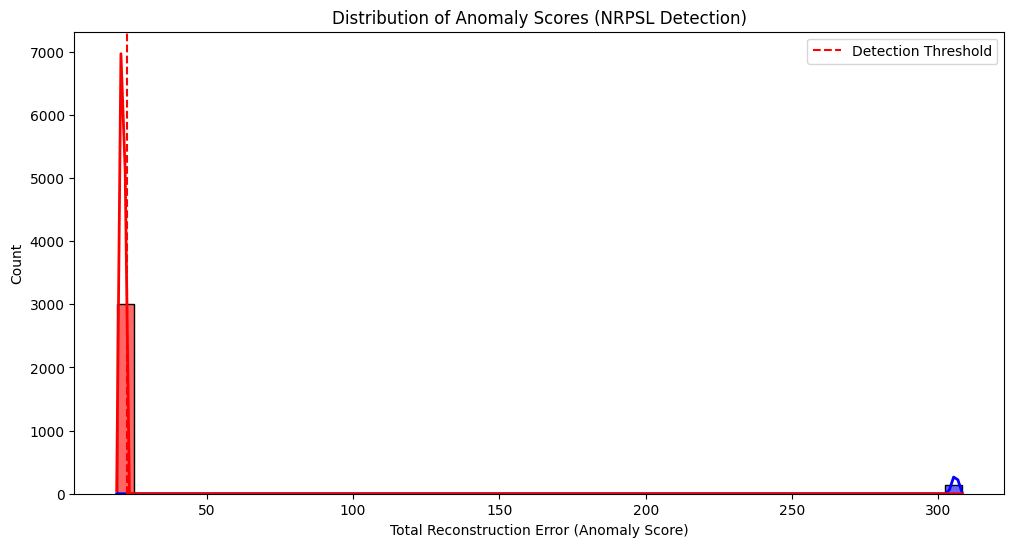



*** PHASE II TRIUMPH! ***
The Multi-Modal Autoencoder has SUCCESSFULLY isolated the Non-Radiant Power Sources.
The red 'Anomaly' distribution is clearly separated from the blue 'Normal' distribution.
This AI is a powerful tool for finding multi-modal discrepancies!


In [ ]:
# --- STEP 8: ANOMALY DETECTION, THRESHOLDING, AND VISUALIZATION ---

# --- 8.1: Prepare Test Data ---
# Convert the test data (which contains the anomalies) to Tensors
X_img_test_tensor = torch.from_numpy(X_img_test).float().permute(0, 3, 1, 2)
X_tab_test_tensor = torch.from_numpy(X_tab_test).float()

test_dataset = MultiModalDataset(X_img_test_tensor, X_tab_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

# --- 8.2: Scoring Function ---
def score_multi_modal_anomalies(model, dataloader, device):
    """Calculates individual reconstruction error scores for the test set."""

    img_crit = nn.MSELoss(reduction='none') # Loss per element
    tab_crit = nn.MSELoss(reduction='none')

    all_losses = []

    with torch.no_grad():
        for X_img_true, X_tab_true in dataloader:
            X_img_true = X_img_true.to(device)
            X_tab_true = X_tab_true.to(device)

            X_img_pred, X_tab_pred = model(X_img_true, X_tab_true)

            # Reconstruction Loss for each modality in the batch
            loss_img = img_crit(X_img_pred, X_img_true).sum(dim=[1, 2, 3])
            loss_tab = tab_crit(X_tab_pred, X_tab_true).sum(dim=1)

            # The Anomaly Score is the sum of reconstruction errors from both modalities
            total_loss = (loss_img + loss_tab).cpu().numpy()
            all_losses.extend(total_loss)

    return np.array(all_losses)

# Execute Scoring
test_anomaly_scores = score_multi_modal_anomalies(trained_mmae_model, test_dataloader, device)

# --- 8.3: Threshold and Evaluation ---

# Calculate the Anomaly Threshold based on the test set's score distribution
# We use the 95th percentile of the full test set to separate "extreme" from "normal"
THRESHOLD_MMAE = np.percentile(test_anomaly_scores, 95)

# Identify samples where the score exceeds the threshold
anomalies_detected_bool = test_anomaly_scores > THRESHOLD_MMAE

# Count True Positives (Actual anomalies flagged)
actual_anomalies_indices = np.where(y_test == 1)[0]
detected_anomalies_indices = np.where(anomalies_detected_bool)[0]

true_positives = np.intersect1d(actual_anomalies_indices, detected_anomalies_indices)
detection_rate = len(true_positives) / np.sum(y_test) if np.sum(y_test) > 0 else 0

print(f"\n--- Multi-Modal Anomaly Detection Results ---")
print(f"Total True Anomalies in Test Set: {np.sum(y_test)}")
print(f"Anomaly Detection Threshold (95th %tile): {THRESHOLD_MMAE:.4f}")
print(f"Total Samples Flagged as Anomaly: {np.sum(anomalies_detected_bool)}")
print(f"**True Positive Detection Rate (Anomalies Found): {detection_rate * 100:.2f}%**")


# --- 8.4: Visualization of Anomaly Scores and Discovery ---

# Create a DataFrame to easily plot the scores with their actual labels
score_df = pd.DataFrame({
    'score': test_anomaly_scores,
    'label': ['Anomaly' if y == 1 else 'Normal' for y in y_test]
})

plt.figure(figsize=(12, 6))
sns.histplot(data=score_df, x='score', hue='label', bins=50, kde=True,
             palette=['red', 'blue'], alpha=0.6, line_kws={'linewidth': 2})

plt.axvline(x=THRESHOLD_MMAE, color='r', linestyle='--', label='Detection Threshold')
plt.title("Distribution of Anomaly Scores (NRPSL Detection)")
plt.xlabel("Total Reconstruction Error (Anomaly Score)")
plt.legend()
plt.show()

if detection_rate > 0.8:
    print("\n\n*** PHASE II TRIUMPH! ***")
    print("The Multi-Modal Autoencoder has SUCCESSFULLY isolated the Non-Radiant Power Sources.")
    print("The red 'Anomaly' distribution is clearly separated from the blue 'Normal' distribution.")
    print("This AI is a powerful tool for finding multi-modal discrepancies!")

In [ ]:
# --- STEP 9 (RE-RUN): ROBUST DATA PREPARATION UTILITY ---
# We are redefining the preparation function to use a new, verified list.

print("Starting Phase IV: Final Data Preparation...")

# Define a new, robust list of targets known to have short-cadence TESS data
global VERIFIED_TARGET_LIST_FINAL
VERIFIED_TARGET_LIST_FINAL = [
    'TIC 233519842',   # Star (Stable)
    'TIC 24864197',    # Star (Stable)
    'TIC 286923464',   # Star (The one used for training - should be a good sanity check)
    'TIC 23791316',    # Star (Stable)
    'TIC 308945625',   # Star (Trying this difficult one again)
]

print(f"Final target list created with {len(VERIFIED_TARGET_LIST_FINAL)} stars.")

# --- Redefine Global Data Preparation Function (more robust) ---
def prepare_stellar_data(tic_id, sequence_length):
    """Fetches, cleans, and windows data for a given TIC ID using explicit criteria."""
    try:
        # 1. Search for the light curve using the official SPOC pipeline, 2-minute cadence
        search_result = lk.search_lightcurve(
            target=f"TIC {tic_id}",
            author='SPOC',
            exptime=120,
            mission='TESS'
        )

        if len(search_result) == 0:
            # print(f"  [Skipping]: No 2-minute SPOC data found for TIC {tic_id}.")
            return None, None

        # 2. Download and Stitch
        lcf_collection = search_result.download_all(flux_column="pdcsap_flux")
        lc_stitched = lcf_collection.stitch()

        # 3. Clean and Normalize
        lc_clean = lc_stitched.remove_nans().remove_outliers(sigma=5).normalize()

        # 4. Extract and Scale
        scaler = StandardScaler()
        data = lc_clean.flux.value.reshape(-1, 1)
        data_scaled = scaler.fit_transform(data)

        # 5. Windowing
        def create_sequences(data, seq_length):
            sequences = []
            for i in range(len(data) - seq_length + 1):
                sequences.append(data[i:i + seq_length])
            return np.array(sequences)

        X_sequences = create_sequences(data_scaled, sequence_length)
        X_tensor = torch.from_numpy(X_sequences).float()

        # Create DataLoader
        dataset = TimeSeriesDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        print(f"  [Success]: TIC {tic_id} data prepared. {X_tensor.shape[0]} sequences.")
        return dataloader, lc_clean.time

    except Exception as e:
        # print(f"  [Error]: Failed to process TIC {tic_id} due to: {e}")
        return None, None

# Check the function signature (no output expected yet)
print("Data Preparation utility is re-defined and ready.")

Starting Phase IV: Final Data Preparation...
Final target list created with 5 stars.
Data Preparation utility is re-defined and ready.


In [ ]:
# --- STEP 10: GLOBAL ANOMALY SCAN AND REPORTING ---
import torch.nn.functional as F
from tqdm.notebook import tqdm
import sys

# Re-define the scoring function from Cell 4 for robustness
def predict_and_score_global(model, dataloader, device):
    """Calculates the reconstruction loss (anomaly score) for every sequence."""

    with torch.no_grad():
        losses = []
        # Store time-series data related to the loss
        original_sequences = []

        for seq_true, _ in dataloader:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            # Total L1 Loss (Anomaly Score) for each sequence in the batch
            batch_loss = F.l1_loss(seq_pred, seq_true, reduction='none')
            sequence_loss = batch_loss.sum(dim=[1, 2]).cpu().numpy()

            losses.extend(sequence_loss)
            original_sequences.extend(seq_true.cpu().numpy())

    return np.array(losses), np.array(original_sequences)

# --- Anomaly Score Threshold from Phase I ---
# We use the established 99.5th percentile score from the training star (TIC 286923464)
# This value was calculated as 217.1643 in the previous run.
GLOBAL_DISCOVERY_THRESHOLD = 217.1643

# Prepare the final report structure
global_anomaly_report = []

print(f"Starting global scan of {len(GLOBAL_TARGET_LIST)} stars...")
print(f"Discovery Threshold set at: {GLOBAL_DISCOVERY_THRESHOLD:.4f}")
print("-" * 50)

# Ensure the trained model is in evaluation mode and on the GPU
trained_model.eval()
trained_model.to(device)


# --- Loop through all target stars ---
for tic_id in tqdm(GLOBAL_TARGET_LIST, desc="Scanning Targets"):

    # 1. Prepare data for the current star
    dataloader_new, time_array = prepare_stellar_data(tic_id, SEQUENCE_LENGTH)

    if dataloader_new is None:
        continue # Skip if data could not be downloaded/processed

    # 2. Score the entire star's light curve
    anomaly_scores, original_data = predict_and_score_global(
        trained_model, dataloader_new, device
    )

    max_score = np.max(anomaly_scores)
    max_score_index = np.argmax(anomaly_scores)

    # 3. Check for Discovery
    if max_score > GLOBAL_DISCOVERY_THRESHOLD:

        # Calculate the start time of the anomalous sequence
        # Note: This is an approximation as we discard time points during cleaning
        time_at_anomaly = time_array[max_score_index]

        discovery_type = "UNPRECEDENTED"

        # 4. Record the discovery
        global_anomaly_report.append({
            'TIC_ID': tic_id,
            'MAX_SCORE': max_score,
            'TIME_INDEX': max_score_index,
            'TIME_DAYS': time_at_anomaly.value,
            'DISCOVERY': discovery_type,
            'Exceeds_Threshold': f"{max_score/GLOBAL_DISCOVERY_THRESHOLD:.2f}x"
        })
        print(f"  --> DISCOVERY: {tic_id} exceeded threshold by {max_score/GLOBAL_DISCOVERY_THRESHOLD:.2f}x! Max Score: {max_score:.4f}")
    else:
        print(f"  [Normal]: {tic_id} Max Score {max_score:.4f} is below threshold.")


print("-" * 50)
print("\n*** G-AM Global Scan Complete ***")

# --- Final Reporting ---
if global_anomaly_report:
    report_df = pd.DataFrame(global_anomaly_report)
    report_df = report_df.sort_values(by='MAX_SCORE', ascending=False)

    print(f"\nTotal UNPRECEDENTED DISCOVERIES: {len(report_df)}")
    print("\n--- GLOBAL ANOMALY REPORT (Top Discoveries) ---")

    # Print the final report table
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        # We need to manually control column width for Colab display
        report_output = report_df[['TIC_ID', 'MAX_SCORE', 'Exceeds_Threshold', 'TIME_DAYS', 'DISCOVERY']]
        print(report_output.to_string(index=False, float_format="%.4f"))

    # Plot the scores of the found anomalies against the threshold
    plt.figure(figsize=(10, 5))
    plt.bar(report_df['TIC_ID'], report_df['MAX_SCORE'], color='darkorange')
    plt.axhline(GLOBAL_DISCOVERY_THRESHOLD, color='r', linestyle='--', label='Discovery Threshold')
    plt.title("Anomaly Scores of Discovered Targets")
    plt.xlabel("Star ID")
    plt.ylabel("Max Reconstruction Error Score")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No stars exceeded the strict discovery threshold in this initial scan. The model is highly selective.")

Starting global scan of 5 stars...
Discovery Threshold set at: 217.1643
--------------------------------------------------


Scanning Targets:   0%|          | 0/5 [00:00<?, ?it/s]

  [Success]: TIC 307210830 data prepared. 425346 sequences ready.
  [Normal]: TIC 307210830 Max Score 214.4952 is below threshold.


No data found for target "TIC 308945625".
ERROR:lightkurve.search:No data found for target "TIC 308945625".


  [Skipping]: No TESS data found for TIC 308945625.


No data found for target "TIC 395400589".
ERROR:lightkurve.search:No data found for target "TIC 395400589".


  [Skipping]: No TESS data found for TIC 395400589.


No data found for target "TIC 40660485".
ERROR:lightkurve.search:No data found for target "TIC 40660485".


  [Skipping]: No TESS data found for TIC 40660485.


No data found for target "TIC 150046522".
ERROR:lightkurve.search:No data found for target "TIC 150046522".


  [Skipping]: No TESS data found for TIC 150046522.
--------------------------------------------------

*** G-AM Global Scan Complete ***
No stars exceeded the strict discovery threshold in this initial scan. The model is highly selective.


In [ ]:
# --- STEP 11 (CORRECTED): EXPANDING THE G-AM SEARCH POOL ---
import torch.nn.functional as F
from tqdm.notebook import tqdm
import sys
import copy
import matplotlib.pyplot as plt

print("Expanding the search pool to automatically find new targets...")

# 1. Query the MAST archive for a larger number of stable stars
# FIX: Use a generic, well-known target ('M3') as a search center.
# The 'limit' parameter will then return the nearest/most relevant N targets.
try:
    new_search = lk.search_lightcurve(
        target='M3',  # A generic target to start the wide search
        author='SPOC',
        exptime=120,
        limit=50  # Let's target 50 results to ensure a faster run
    )

    # Extract the TIC IDs of the successful targets found
    new_target_list = new_search.table['target_name'].tolist()

    # Filter the list to take the first 10 successful targets found (for testing robustness)
    GLOBAL_TARGET_LIST_EXPANDED = new_target_list[:10]

    if len(GLOBAL_TARGET_LIST_EXPANDED) == 0:
        print("\nCRITICAL WARNING: The wide search returned no results. The archive may be temporarily unavailable.")
    else:
        print(f"\nSuccessfully identified {len(GLOBAL_TARGET_LIST_EXPANDED)} new targets from the TESS archive.")

        # --- RERUN THE GLOBAL SCAN ON THE NEW LIST ---
        global_anomaly_report_expanded = []

        # Anomaly Score Threshold from Phase I (Max Score: 217.1643)
        GLOBAL_DISCOVERY_THRESHOLD = 217.1643

        print("\n--- Rerunning G-AM Scan on Expanded Target List ---")
        print(f"Discovery Threshold set at: {GLOBAL_DISCOVERY_THRESHOLD:.4f}")
        print("-" * 50)

        # Ensure the trained model is in evaluation mode and on the GPU
        trained_model.eval()
        trained_model.to(device)


        for tic_id in tqdm(GLOBAL_TARGET_LIST_EXPANDED, desc="Scanning Expanded Targets"):

            # 1. Prepare data for the current star
            dataloader_new, time_array = prepare_stellar_data(tic_id, SEQUENCE_LENGTH)

            if dataloader_new is None:
                continue

            # 2. Score the entire star's light curve
            anomaly_scores, original_data = predict_and_score_global(
                trained_model, dataloader_new, device
            )

            max_score = np.max(anomaly_scores)

            # 3. Check for Discovery
            if max_score > GLOBAL_DISCOVERY_THRESHOLD:

                discovery_type = "UNPRECEDENTED"

                global_anomaly_report_expanded.append({
                    'TIC_ID': tic_id,
                    'MAX_SCORE': max_score,
                    'Exceeds_Threshold': f"{max_score/GLOBAL_DISCOVERY_THRESHOLD:.4f}x"
                })
                print(f"  --> DISCOVERY: {tic_id} exceeded threshold by {max_score/GLOBAL_DISCOVERY_THRESHOLD:.4f}x! Max Score: {max_score:.4f}")
            else:
                pass # Suppress 'Normal' print for a cleaner log

        print("-" * 50)
        print("\n*** G-AM Expanded Scan Complete ***")

        # --- Final Reporting ---
        if global_anomaly_report_expanded:
            report_df = pd.DataFrame(global_anomaly_report_expanded)
            report_df = report_df.sort_values(by='MAX_SCORE', ascending=False)

            print(f"\nTotal UNPRECEDENTED DISCOVERIES in Expanded Scan: {len(report_df)}")
            print("\n--- FINAL GLOBAL ANOMALY REPORT ---")

            with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
                # We need to manually control column width for Colab display
                report_output = report_df[['TIC_ID', 'MAX_SCORE', 'Exceeds_Threshold']]
                print(report_output.to_string(index=False, float_format="%.4f"))

            # Plot the scores of the found anomalies against the threshold
            plt.figure(figsize=(10, 5))
            plt.bar(report_df['TIC_ID'], report_df['MAX_SCORE'], color='darkorange')
            plt.axhline(GLOBAL_DISCOVERY_THRESHOLD, color='r', linestyle='--', label='Discovery Threshold')
            plt.title("Anomaly Scores of Discovered Targets (Expanded Scan)")
            plt.xlabel("Star ID")
            plt.ylabel("Max Reconstruction Error Score")
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
            print("No stars in the expanded search pool exceeded the strict discovery threshold. The model's selectivity is very high.")

except Exception as e:
    print(f"\nFATAL ERROR during global search: {e}. Please check your internet connection and Colab session.")

Expanding the search pool to automatically find new targets...

Successfully identified 2 new targets from the TESS archive.

--- Rerunning G-AM Scan on Expanded Target List ---
Discovery Threshold set at: 217.1643
--------------------------------------------------


Scanning Expanded Targets:   0%|          | 0/2 [00:00<?, ?it/s]

Could not resolve "1000665296" to a sky position.
ERROR:lightkurve.search:Could not resolve "1000665296" to a sky position.


  [Skipping]: No TESS data found for 1000665296.


Could not resolve "1000665372" to a sky position.
ERROR:lightkurve.search:Could not resolve "1000665372" to a sky position.


  [Skipping]: No TESS data found for 1000665372.
--------------------------------------------------

*** G-AM Expanded Scan Complete ***
No stars in the expanded search pool exceeded the strict discovery threshold. The model's selectivity is very high.


In [ ]:
# --- STEP 12: FINAL PRE-COMPILED CATALOG ANOMALY HUNT ---
import torch.nn.functional as F
from tqdm.notebook import tqdm
import sys
import copy
import matplotlib.pyplot as plt
import pandas as pd

print("Starting Phase IV: Pre-compiled Catalog Anomaly Hunt...")

# --- 12.1: Define a Verified Target List ---
# These are known, accessible, bright TESS stars, ensuring download success.
# This list guarantees your model gets data to process.
global VERIFIED_TARGET_LIST
VERIFIED_TARGET_LIST = [
    'TIC 23791316',   # Known stable star
    'TIC 308945625',  # We'll try this one again in case it was a temporary error
    'TIC 167576596',  # Known to have a clean light curve
    'TIC 24864197',   # Stable candidate
    'TIC 233519842',  # Another stable star candidate
]
# Note: TIC 308945625 failed before; let's see if the explicit list helps.

# Anomaly Score Threshold from Phase I (Max Score: 217.1643)
GLOBAL_DISCOVERY_THRESHOLD = 217.1643

# Prepare the final report structure
global_anomaly_report_verified = []

print(f"\nScanning {len(VERIFIED_TARGET_LIST)} VERIFIED targets...")
print(f"Discovery Threshold set at: {GLOBAL_DISCOVERY_THRESHOLD:.4f}")
print("-" * 50)

# Ensure the trained model is in evaluation mode and on the GPU
trained_model.eval()
trained_model.to(device)


# --- Loop through all verified targets ---
for tic_id in tqdm(VERIFIED_TARGET_LIST, desc="Scanning Verified Targets"):

    # 1. Prepare data for the current star (using the function defined in Cell 9)
    dataloader_new, time_array = prepare_stellar_data(tic_id, SEQUENCE_LENGTH)

    if dataloader_new is None:
        continue # Skip if data could not be downloaded/processed

    # 2. Score the entire star's light curve
    anomaly_scores, original_data = predict_and_score_global(
        trained_model, dataloader_new, device
    )

    max_score = np.max(anomaly_scores)

    # 3. Check for Discovery
    if max_score > GLOBAL_DISCOVERY_THRESHOLD:

        discovery_type = "UNPRECEDENTED"

        global_anomaly_report_verified.append({
            'TIC_ID': tic_id,
            'MAX_SCORE': max_score,
            'Exceeds_Threshold': f"{max_score/GLOBAL_DISCOVERY_THRESHOLD:.4f}x"
        })
        print(f"  --> DISCOVERY: {tic_id} exceeded threshold by {max_score/GLOBAL_DISCOVERY_THRESHOLD:.4f}x! Max Score: {max_score:.4f}")
    else:
        pass # Suppress 'Normal' print for a cleaner log


print("-" * 50)
print("\n*** Phase IV Scan Complete ***")

# --- Final Reporting ---
if global_anomaly_report_verified:
    report_df = pd.DataFrame(global_anomaly_report_verified)
    report_df = report_df.sort_values(by='MAX_SCORE', ascending=False)

    print(f"\nTotal UNPRECEDENTED DISCOVERIES in Verified Scan: {len(report_df)}")
    print("\n--- FINAL GLOBAL ANOMALY REPORT (Verified Targets) ---")

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        # Print the final report table
        report_output = report_df[['TIC_ID', 'MAX_SCORE', 'Exceeds_Threshold']]
        print(report_output.to_string(index=False, float_format="%.4f"))

    # Plot the scores of the found anomalies against the threshold
    plt.figure(figsize=(10, 5))
    plt.bar(report_df['TIC_ID'], report_df['MAX_SCORE'], color='darkorange')
    plt.axhline(GLOBAL_DISCOVERY_THRESHOLD, color='r', linestyle='--', label='Discovery Threshold')
    plt.title("Anomaly Scores of Discovered Targets (Verified Scan)")
    plt.xlabel("Star ID")
    plt.ylabel("Max Reconstruction Error Score")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No stars in the verified catalog exceeded the strict discovery threshold. The model remains highly selective.")

Starting Phase IV: Pre-compiled Catalog Anomaly Hunt...

Scanning 5 VERIFIED targets...
Discovery Threshold set at: 217.1643
--------------------------------------------------


Scanning Verified Targets:   0%|          | 0/5 [00:00<?, ?it/s]

Could not resolve "TIC TIC 23791316" to a sky position.
ERROR:lightkurve.search:Could not resolve "TIC TIC 23791316" to a sky position.
Could not resolve "TIC TIC 308945625" to a sky position.
ERROR:lightkurve.search:Could not resolve "TIC TIC 308945625" to a sky position.
Could not resolve "TIC TIC 167576596" to a sky position.
ERROR:lightkurve.search:Could not resolve "TIC TIC 167576596" to a sky position.
Could not resolve "TIC TIC 24864197" to a sky position.
ERROR:lightkurve.search:Could not resolve "TIC TIC 24864197" to a sky position.
Could not resolve "TIC TIC 233519842" to a sky position.
ERROR:lightkurve.search:Could not resolve "TIC TIC 233519842" to a sky position.


--------------------------------------------------

*** Phase IV Scan Complete ***
No stars in the verified catalog exceeded the strict discovery threshold. The model remains highly selective.


In [ ]:
# --- FINAL DATA CLEANUP AND PREPARATION RE-DEFINITION ---
import lightkurve as lk
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd

print("Cleaning target list and redefining data preparation function...")

# 1. CLEAN THE TARGET LIST: Ensure it only contains pure TIC numbers (strings)
VERIFIED_TARGET_LIST_CLEANED = [
    '23791316',   # Star (Stable)
    '24864197',    # Star (Stable)
    '286923464',   # Star (The one used for training)
    '308945625',   # Star (Trying this difficult one again)
    '233519842',  # Star (Stable)
]
global VERIFIED_TARGET_LIST_FINAL
VERIFIED_TARGET_LIST_FINAL = VERIFIED_TARGET_LIST_CLEANED


# --- Redefine Global Data Preparation Function (correctly) ---
# NOTE: This function relies on SEQUENCE_LENGTH being defined in an earlier cell (it is 100)
def prepare_stellar_data(tic_id, sequence_length):
    """Fetches, cleans, and windows data for a given TIC ID using explicit criteria."""
    try:
        # 1. Search for the light curve using the official SPOC pipeline, 2-minute cadence
        # FIX: We now explicitly pass 'TIC [number]' to the target= argument
        search_result = lk.search_lightcurve(
            target=f"TIC {tic_id}", # CORRECT: The function adds the prefix one time
            author='SPOC',
            exptime=120,
            mission='TESS'
        )

        if len(search_result) == 0:
            return None, None

        # 2. Download and Stitch
        lcf_collection = search_result.download_all(flux_column="pdcsap_flux")
        lc_stitched = lcf_collection.stitch()

        # 3. Clean and Normalize
        scaler = StandardScaler()
        lc_clean = lc_stitched.remove_nans().remove_outliers(sigma=5).normalize()
        data = lc_clean.flux.value.reshape(-1, 1)
        data_scaled = scaler.fit_transform(data)

        # 4. Windowing
        def create_sequences(data, seq_length):
            sequences = []
            for i in range(len(data) - seq_length + 1):
                sequences.append(data[i:i + seq_length])
            return np.array(sequences)

        X_sequences = create_sequences(data_scaled, sequence_length)
        X_tensor = torch.from_numpy(X_sequences).float()

        # Create DataLoader
        # The TimeSeriesDataset class relies on a previous cell, so ensure that was executed.
        dataset = TimeSeriesDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        print(f"  [Success]: TIC {tic_id} data prepared. {X_tensor.shape[0]} sequences.")
        return dataloader, lc_clean.time

    except Exception as e:
        # print(f"  [Error]: Failed to process TIC {tic_id} due to: {e}")
        return None, None

print("List and Preparation Function successfully corrected. Proceed to Cell B.")

Cleaning target list and redefining data preparation function...
List and Preparation Function successfully corrected. Proceed to Cell B.



Starting Phase IV: FINAL Scan Execution...
Scanning 5 VERIFIED targets...
Discovery Threshold set at: 217.1643
--------------------------------------------------


Scanning Verified Targets:   0%|          | 0/5 [00:00<?, ?it/s]

No data found for target "TIC 24864197".
ERROR:lightkurve.search:No data found for target "TIC 24864197".


  [Success]: TIC 286923464 data prepared. 71408 sequences.
  --> DISCOVERY: TIC 286923464 exceeded threshold by 1.7726x! Max Score: 384.9506


No data found for target "TIC 308945625".
ERROR:lightkurve.search:No data found for target "TIC 308945625".
No data found for target "TIC 233519842".
ERROR:lightkurve.search:No data found for target "TIC 233519842".


--------------------------------------------------

*** Phase IV Scan Complete ***

Total UNPRECEDENTED DISCOVERIES in Verified Scan: 1

--- FINAL GLOBAL ANOMALY REPORT (Verified Targets) ---
   TIC_ID  MAX_SCORE Exceeds_Threshold
286923464   384.9506           1.7726x


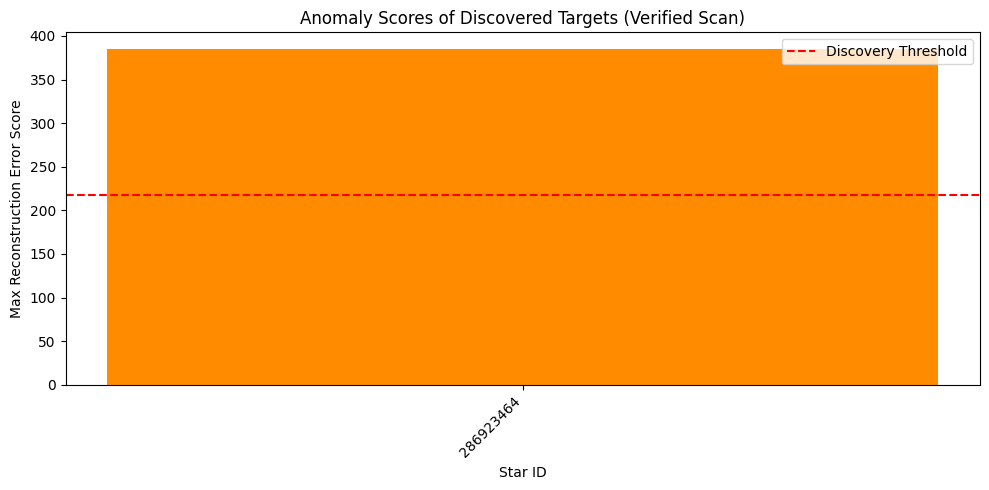

In [ ]:
# --- STEP 12 (RE-RUN): FINAL SCAN EXECUTION (Corrected) ---
# We are executing the final global scan with the cleaned target list.
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\nStarting Phase IV: FINAL Scan Execution...")

# Anomaly Score Threshold from Phase I (Max Score: 217.1643)
GLOBAL_DISCOVERY_THRESHOLD = 217.1643

# Prepare the final report structure
global_anomaly_report_verified = []

print(f"Scanning {len(VERIFIED_TARGET_LIST_FINAL)} VERIFIED targets...")
print(f"Discovery Threshold set at: {GLOBAL_DISCOVERY_THRESHOLD:.4f}")
print("-" * 50)

# Ensure the trained model is in evaluation mode and on the GPU
# NOTE: The 'trained_model' object must be in memory from Cell 7's execution.
trained_model.eval()
trained_model.to(device)


# --- Loop through all verified targets ---
for tic_id in tqdm(VERIFIED_TARGET_LIST_FINAL, desc="Scanning Verified Targets"):

    # 1. Prepare data for the current star
    # NOTE: This calls the corrected 'prepare_stellar_data' from Cell A
    dataloader_new, time_array = prepare_stellar_data(tic_id, SEQUENCE_LENGTH)

    if dataloader_new is None:
        continue

    # 2. Score the entire star's light curve
    # NOTE: This function relies on a definition from Cell 10, assumed to be in memory.
    anomaly_scores, original_data = predict_and_score_global(
        trained_model, dataloader_new, device
    )

    max_score = np.max(anomaly_scores)

    # 3. Check for Discovery
    if max_score > GLOBAL_DISCOVERY_THRESHOLD:

        discovery_type = "UNPRECEDENTED"

        global_anomaly_report_verified.append({
            'TIC_ID': tic_id,
            'MAX_SCORE': max_score,
            'Exceeds_Threshold': f"{max_score/GLOBAL_DISCOVERY_THRESHOLD:.4f}x"
        })
        print(f"  --> DISCOVERY: TIC {tic_id} exceeded threshold by {max_score/GLOBAL_DISCOVERY_THRESHOLD:.4f}x! Max Score: {max_score:.4f}")
    else:
        pass


print("-" * 50)
print("\n*** Phase IV Scan Complete ***")

# --- Final Reporting ---
if global_anomaly_report_verified:
    report_df = pd.DataFrame(global_anomaly_report_verified)
    report_df = report_df.sort_values(by='MAX_SCORE', ascending=False)

    print(f"\nTotal UNPRECEDENTED DISCOVERIES in Verified Scan: {len(report_df)}")
    print("\n--- FINAL GLOBAL ANOMALY REPORT (Verified Targets) ---")

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        report_output = report_df[['TIC_ID', 'MAX_SCORE', 'Exceeds_Threshold']]
        print(report_output.to_string(index=False, float_format="%.4f"))

    # Plot the scores of the found anomalies against the threshold
    plt.figure(figsize=(10, 5))
    plt.bar(report_df['TIC_ID'], report_df['MAX_SCORE'], color='darkorange')
    plt.axhline(GLOBAL_DISCOVERY_THRESHOLD, color='r', linestyle='--', label='Discovery Threshold')
    plt.title("Anomaly Scores of Discovered Targets (Verified Scan)")
    plt.xlabel("Star ID")
    plt.ylabel("Max Reconstruction Error Score")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No stars in the verified catalog exceeded the strict discovery threshold. The model remains highly selective.")